# Simulation de la capture d'insectes dans des pots Barbers, en fonction de leur densité et de leur motilité 


Intro à rédiger - Qu'est-ce qu'un pot Barber ? Pourquoi est-ce qu'il ne mesure pas réellement la densité ? Est-ce qu'on peut y remédier ?!

[Pot Barber.jpg](attachment:2a922033-28fe-44c7-846f-bb7ba2b2064e.jpg)
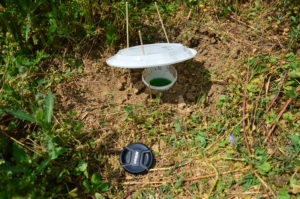

##### Import des bibliothèques utiles

In [1]:
from typing import Tuple

import numpy as np
from numpy import random

from matplotlib import animation, rc
import matplotlib.pyplot as plt
import itertools

NB : Pour faire tourner ce code, j'ai du installer ffmpeg-python (taper *conda install ffmpeg-python* dans la console Ananconda Anaconda-Prompt) et pygraphviz (taper *conda install pygraphviz* dans la console Ananconda Anaconda-Prompt)

In [2]:
rc('animation', html='html5')

## 1. Modèle à une seule espèce

### Partie 1. Définitions

#### Définition du champ

On se place dans un champs d'un hectare (100 m par 100 m) dans lequel se déplacent un certains nombres d'insectes au sol. Dans ce champs on a placé un/des Pot Barber pour capturer les insectes afin d'estimer leur densité.

<font color='blue'> *Là il faut afficher une image toute bête du champ, avec éventuellement un ou plusieurs pot Barber dedans* </font>

In [3]:
%%capture

fig = plt.figure()

ax = fig.add_subplot(
    aspect="equal",
    xlim=(0, 100),
    ylim=(0, 100)
)

#### Modalités de déplacement des insectes

On considère que le déplacement des insectes est isotrope (il est equiprobable dans toutes les directions) et que la distance qu'ils parcourent à chaque pas de temps est aléatoire (tirée dans une loi normale par exemple).

Le déplacement des insectes à chaque pas de temps sera défini par un vecteur dont la direction (celle que va prendre l'insecte) est aléatoire, et dont la norme (qui correspond à la distance que va parcourir l'insecte) est tirée dans une loi normale.

<font color='blue'> *Plus tard on pourra imaginer - (i) Ajouter plusieurs espèces avec des capacités de dispersion différentes / (ii) Ajouter des mouvements pas tout à fait random / (iii) Ajouter des mouvements qui dépendent de l'habitat.* </font>

<font color='green'> **Question Possible** : A partir de la fonction *random_unit_vector()* ci-dessous qui renvoie un vecteur unité dont la direction est aléatoire, construire une fonction *random_walk_vector()* dont la direction est aléatoire et la norme tirée dans une loi normale de moyenne mu = 1 et d'écart-type sigma = 0.5. Indice : la fonction np.random.normal(mu, sigma) renvoie une valeure tirée dans une valeure tirée dans une loi normale de moyenne mu et d'écart-type sigma  </font>

<font color='green'> **Solution** </font>

In [4]:
mu = 2 ; sigma = 2

def random_walk_vector(mu, sigma) :
    
    """Gets a random vector (random direction, gaussian norm)"""
    
    norm = np.random.normal(mu, sigma)
    angle = random.random() * 2 * np.pi
    
    return norm*np.cos(angle), norm*np.sin(angle)

#### Définition du déplacement

Dans cette section, on simule le déplacement d'un insecte sur *num_steps = 100* pas de temps. Le déplacement de l'insecte est défini comme  la suite de ses localisations successives, stockées dans une matrice de taille *2 x num_steps*.

Conditions aux bords : Réfléchissante ou rebondissante, les deux sont possibles. Ici on choisit réflechissante.

In [5]:
num_steps = 100

def get_random_walk(num_steps, mu, sigma) :
    
    locations = np.zeros((2, num_steps))
    
    for i in range(1, num_steps):
        
        next_x, next_y = random_walk_vector(mu, sigma)
        locations[0, i] = abs(min(locations[0, i-1] + next_x, 100))
        locations[1, i] = abs(min(locations[1, i-1] + next_y, 100))
        
    return locations

#### Définition de la capture

<font color='green'> **Question Possible** : On suppose que le pot Barber est placé au milieu du champs (sur le point de coordonnées [50,50]), et qu'il a un rayon de 0.1m. Ecrire une fonction *is_trapped()* qui prédit si l'insecte est capturé ou non en fonction de sa localisation. </font>

<font color='green'> **Solution Possible** </font>

In [6]:
def is_trapped(location, location_Barber, radius_Barber) :
    
    x, y = location
    x_Barber, y_Barber = location_Barber
    
    return (x - x_Barber)**2 + (y - y_Barber)**2 <= radius_Barber**2

### Partie 2. Simulations

#### Simulation du déplacement et de la capture de plusieurs insectes

On considère maintenant num_inds = 10 insectes qui se déplacent sur le champs, pendant num_steps = 100 pas de temps, selon les modalités définies plus haut dans la fonction *random_walk_vector()*. On suppose que le pot Barber est placé au même endroit qu'à la question précédente (sur le point de coordonnées [50,50]), et qu'il a toujours un rayon de 0,1 m.

<font color='green'> Pas de questions ici, parce que c'est un peu fastidieux. On peut donner le code directement </font>

In [7]:
def Simulate_random_walk(num_steps, num_inds, mu, sigma, location_Barber, radius_Barber) :
    
    # On initialise un dictionnaire pour stocker le déplacement de chaque individu,
    # Et une liste pour stocker le numéro des individus dans l'évnetualité qu'ils soient piégés
    
    Locationss = {}
    dict_Trapped = {} # On récupère dans ce dictionnaire le moment ou l'insecte se fait piégé (s'il se fait piégé bien sur)
    
    for ind in range(num_inds) :
        
        # On définit au hasard une localisation initiale pour chaque insecte
        locations = [[np.random.randint(0,100), np.random.randint(0,100)]]
        
        for i in range(1, num_steps):
        
            next_x, next_y = random_walk_vector(mu, sigma)
            new_location = [locations[i-1][0] + next_x, locations[i-1][1] + next_y]
            
            if is_trapped(new_location, location_Barber, radius_Barber) :
                
                dict_Trapped[ind] = i
                locations[i:num_steps] = [[0,0]]*(num_steps - i + 1)
                
                break
                
            else :
            
                locations.append(new_location)
            
        Locationss[ind] = locations
    
    # Si le dictionnaire n'est pas vide, i.e des insectes on été piégés, alors on va chercher la liste 
    # Number_of_trapped_individuals_per_step donnant le nombre d'insectes dans le piège en fonction du temps,
    # à partir du dictionnaire dict_Trapped.
        
    if bool(dict_Trapped) :
        
        Number_of_trapped_individuals_per_step = [sum([int(bool(i > value)) 
                                                           for value in dict_Trapped.values()])
                                                  for i in range(num_steps)]
        
    return Locationss, Number_of_trapped_individuals_per_step

#### Implémentation de la simulation

*Assignation des valeurs des paramètres pour la simulation*

On affiche notre simulation grâce à la bibliothèque *animation*. Tous les paramètres de la simulation, qui sont les paramètres des fonctions ci-dessus sont modifiables dans la cellule ci-dessous :

In [8]:
num_steps = 100 ; num_inds = 100
mu = 2 ; sigma = 2
location_Barber = [50,50] ; radius_Barber = 5

*Définition de la figure intiale*

In [9]:
%%capture

fig = plt.figure()

ax = fig.add_subplot(aspect="equal",
                     xlim=(0, 100),
                     ylim=(0, 100))

previous_steps, = plt.plot([], [], 'ro', alpha=0.2)
current_steps, = plt.plot([], [], 'ro', alpha=1.0)

Trapped_text = ax.text(0.02, 1.05, "", transform=ax.transAxes)

*Définition de la fonction de rafraichissement de la figure à chaque pas de temps*

In [10]:
def update_plot(step_num):
    
    previous_locs = []
    for i in range(num_inds) :
        previous_locs = previous_locs + Locationss[i][:step_num]
        
    current_locs = [Locationss[i][step_num] for i in range(num_inds)]
    
    previous_steps.set_data([previous_locs[i][0] for i in range(len(previous_locs))],
                            [previous_locs[i][1] for i in range(len(previous_locs))])
    current_steps.set_data([current_locs[i][0] for i in range(len(current_locs))],
                           [current_locs[i][1] for i in range(len(current_locs))])
    
    Trapped_text.set_text("Number of trapped individuals = {}".format(Number_of_trapped_individuals_per_step[step_num]))
        
    return previous_steps, current_steps, Trapped_text

*Lancement de l'animation*

In [11]:
Locationss, Number_of_trapped_individuals_per_step = Simulate_random_walk(num_steps, num_inds, mu, sigma, location_Barber, radius_Barber)

Random_walk = animation.FuncAnimation(
    fig,
    update_plot,
    num_steps,
    interval=500,
)

Random_walk

<font color='blue'> On peut jouer avec les différents paramètre du modèle ici (nombre d'insectes, capacités de dispersion et taille du pot Barber pour voir ce que ça donne... - En particulier, on peut esssayer de tracer le nombre d'individus piégés en fonction de leur capacité de dispersion - Enfin, à priori c'est droit et ça n'a aucun intérêt. On peut définir des modalités de de déplacement plus complexes, pour voir comment elles affectent la relation entre abondance d'insectes et nombre d'individus piégés. - Par exemple des stratégies d'évitement de ses semblables, ou au contraire de rapprochement - marche aussi avec les autres espèces. |  </font>

## 2. Modèle à plusieurs espèces